In [390]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import instance_maker as ins
import algorithms as algo

#repeat the experiment and take the average cost
#change it to 100 if you want to reproduce the result, though it will be slow. 
experiment_num = 100

#fixed parameters
time_length = 2000
interval_mean = 2
shape = 2
price_mean = 50

#enumerating parameters
price_dists = ["Uniform", "Normal", "Pareto"]
Lambdas = [1, 0.6, 0.4]
perturb_probabilitys = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
algorithms = ["SUM", "FSUM", r'SUM$_w$', "PFSUM"]
for Lambda in Lambdas:
    algorithms.append("PDLA({}={})".format(r'$\lambda$', Lambda))

#competitive ratios
result_crs = []


In [391]:
#evaluate algorithms
def evaluate(instance, noisy_instance, parameter_sets, price_dist, perturb_prob):
    for param in parameter_sets:
        beta = param[0]
        T = param[1]
        C = param[2]
        w = int(T / 2) 
        
        offline_cost, offline_solution = algo.OFFLINE_OPTIMAL(instance, T, C, beta)
        noisy_offline_cost, noisy_offline_solution = algo.OFFLINE_OPTIMAL(noisy_instance, T, C, beta)
        noisy_prediction = ins.prediction_generator(noisy_instance, T)
        noisy_w_prediction = ins.prediction_generator(noisy_instance, w)

        sum_cost, sum_solution = algo.SUM(instance, T, C, beta)
        fsum_cost, fsum_solution = algo.FSUM(instance, T, C, beta, noisy_prediction)
        sum_w_cost, sum_w_solution = algo.SUM_W(instance, T, C, beta, noisy_w_prediction)
        pfsum_cost, pfsum_solution = algo.PFSUM(instance, T, C, beta, noisy_prediction)

        result_crs.append(("SUM", beta, T, perturb_prob, price_dist, C, sum_cost / offline_cost))
        result_crs.append(("FSUM", beta, T, perturb_prob, price_dist, C, fsum_cost / offline_cost))
        result_crs.append((r'SUM$_w$', beta, T, perturb_prob, price_dist, C, sum_w_cost / offline_cost))
        result_crs.append(("PFSUM", beta, T, perturb_prob, price_dist, C, pfsum_cost / offline_cost))

        for Lambda in Lambdas:
            pdla_cost, pdla_solution = algo.PDLA_FOR_BAHNCARD(instance, T, C, beta, Lambda, noisy_offline_solution)
            result_crs.append(("PDLA({}={})".format(r'$\lambda$', Lambda), beta, T, perturb_prob, price_dist, C, pdla_cost / offline_cost))

            
#plot results
def plot_cr(beta, T, C, price_dist, profile):
    points = {}
    for algo in algorithms:
        points[algo] = {}
        for perturb_prob in perturb_probabilitys:
            points[algo][perturb_prob] = [0, 0, []]

    #r[0: algorithm; 1: beta; 2: T; 3: perturb_prob; 4: price_dict; 5: C; 6: CR]
    #points[algorithm][perturb_prob][0: sum of CR; 1: number; 2: list of CR]
    for r in result_crs:
        if (r[1] != beta or r[2] != T or r[4] != price_dist or r[5] != C): continue
        points[r[0]][r[3]][0] += r[6]
        points[r[0]][r[3]][1] += 1
        points[r[0]][r[3]][2].append(r[6])
    
    ls = ['-', '-', '-', '-', ':', ':', ':']
    marker = ['', '^', 's', 'o', '', '^', 'o']
    plot_list = []

    legend_anchor = [0.60, 0.60]
    if (profile == "Occasional_travelers"):
        legend_anchor[0] = 0.85
        legend_anchor[1] = 0.50

    fi = plt.figure()
    fi.set_rasterized(True)
    f = fi.add_subplot()
    f.set_rasterized(True)
    
    idx = 0
    for algo in algorithms:
        l = []
        l_ci_upper = []
        l_ci_lower = []
        for perturb_prob in perturb_probabilitys:
            mean = points[algo][perturb_prob][0] / points[algo][perturb_prob][1]
            l.append(mean)
            points[algo][perturb_prob][2].sort()
            num = len(points[algo][perturb_prob][2])
            #90% confidence intervals
            l_ci_upper.append(points[algo][perturb_prob][2][int(num * 0.95)])
            l_ci_lower.append(points[algo][perturb_prob][2][int(num * 0.05)])

        if (algo == "PFSUM"):
            f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'red', alpha=0.2)
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='red', label=algo)
            plot_list.append(p)

        elif (algo == "FSUM"):
            f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'green', alpha=0.1)  
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='green', label=algo)
            plot_list.append(p)

        elif (algo[:4] == "PDLA"):
            f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'gray', alpha=0.1) 
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='gray', label=algo)
            plot_list.append(p)
        elif (algo == r'SUM$_w$'):
            f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'blue', alpha=0.1) 
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='blue', label=algo)
            plot_list.append(p)
        else:
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='black', label=algo)
            plot_list.append(p)
        
        idx += 1

    print("{}, Beta = {}, T = {}, C = {}, Price distribution = {}".format(profile, beta, T, C, price_dist))
    plt.xlabel("Perturbing probability", fontsize=22)
    plt.ylabel("Competitive ratio", fontsize=22)
    f.tick_params(labelsize=17)
    if (profile == "Occasional_travelers"):
        first_legend = f.legend(handles = plot_list[4:7], loc = 'center left', bbox_to_anchor = (0, legend_anchor[0]), prop = {'size': 13}, framealpha=0.5)
        plt.gca().add_artist(first_legend)
        f.legend(handles = plot_list[0:4], loc = 'center left', bbox_to_anchor = (0, legend_anchor[1]), prop = {'size': 13}, framealpha=0.5)
    else:
        first_legend = f.legend(handles = plot_list[4:7], loc = 'center left', bbox_to_anchor = (0, legend_anchor[0]), prop = {'size': 13}, framealpha=0.5)
        plt.gca().add_artist(first_legend)
        f.legend(handles = plot_list[0:4], loc = 'center right', bbox_to_anchor = (1, legend_anchor[1]), prop = {'size': 13}, framealpha=0.5)
    plt.gcf().subplots_adjust(left = 0.14, bottom = 0.14)
    fi.savefig("./figs/{}_{}_beta_{}_T_{}_C_{}_results.eps".format(profile, price_dist, beta, T, C), bbox_inches="tight", format='eps', pad_inches=0.005)
    plt.show()



In [392]:
#for the commuters, travel requests arise steadily every day
parameter_sets = [(0.8, 10, 100), (0.6, 5, 100), (0.6, 10, 200), (0.6, 10, 2000), (0.2, 10, 400)]

for price_dist in price_dists:
    for exp_count in range(0, experiment_num):
        #generate an instance
        np.random.seed(exp_count)
        instance = ins.instance_generator(time_length, "EveryDay", 0, price_dist, price_mean)
        for perturb_prob in perturb_probabilitys:
            noisy_instance = ins.noisy_instance_generator(instance, price_dist, price_mean, perturb_prob)
            evaluate(instance, noisy_instance, parameter_sets, price_dist, perturb_prob)


Commuters, Beta = 0.8, T = 10, C = 100, Price distribution = Uniform


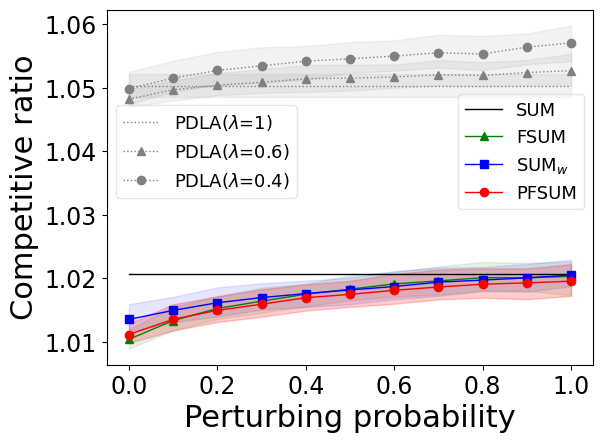

Commuters, Beta = 0.8, T = 10, C = 100, Price distribution = Normal


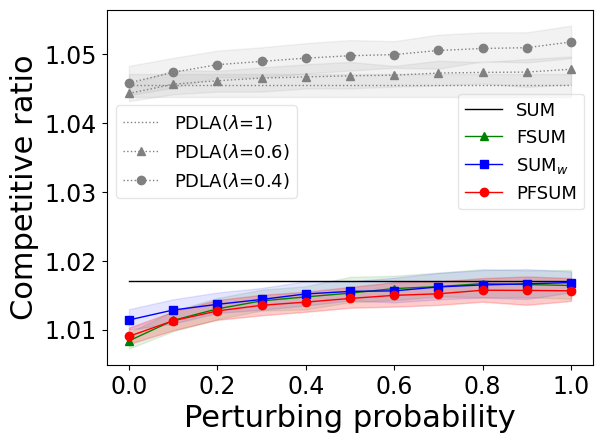

Commuters, Beta = 0.8, T = 10, C = 100, Price distribution = Pareto


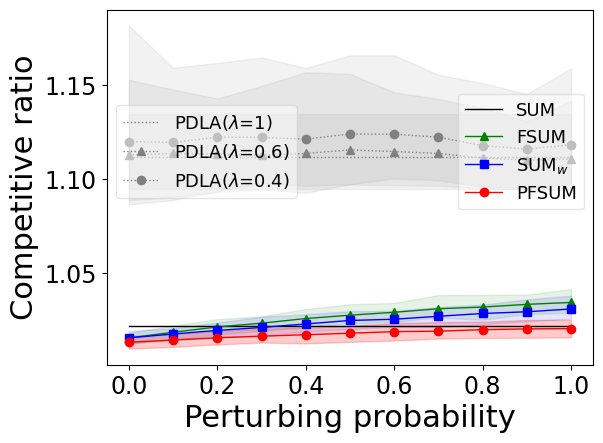

Commuters, Beta = 0.6, T = 5, C = 100, Price distribution = Uniform


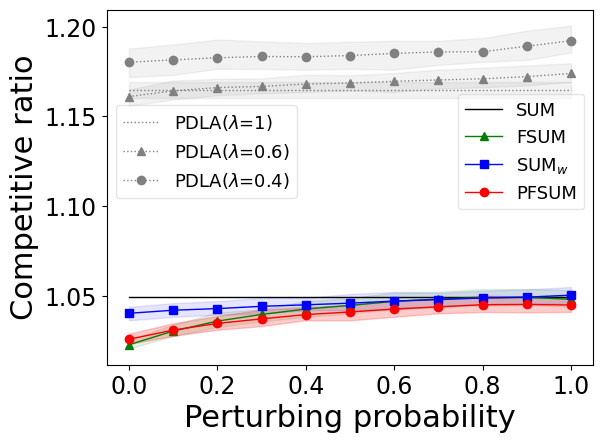

Commuters, Beta = 0.6, T = 5, C = 100, Price distribution = Normal


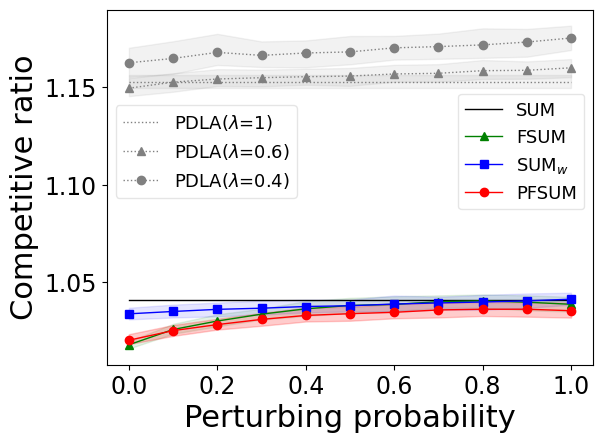

Commuters, Beta = 0.6, T = 5, C = 100, Price distribution = Pareto


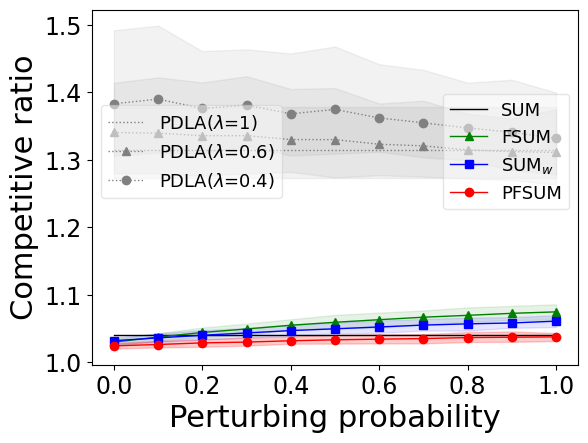

Commuters, Beta = 0.6, T = 10, C = 200, Price distribution = Uniform


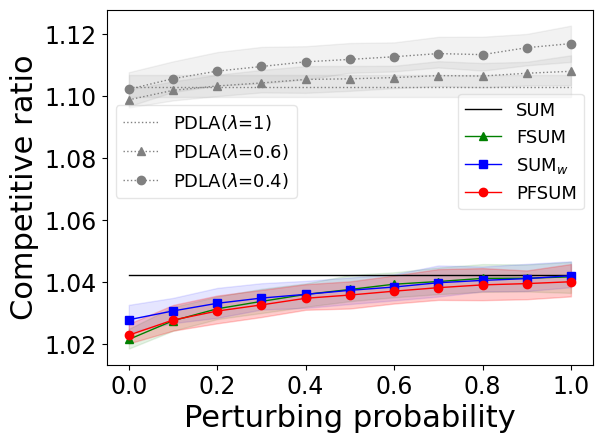

Commuters, Beta = 0.6, T = 10, C = 200, Price distribution = Normal


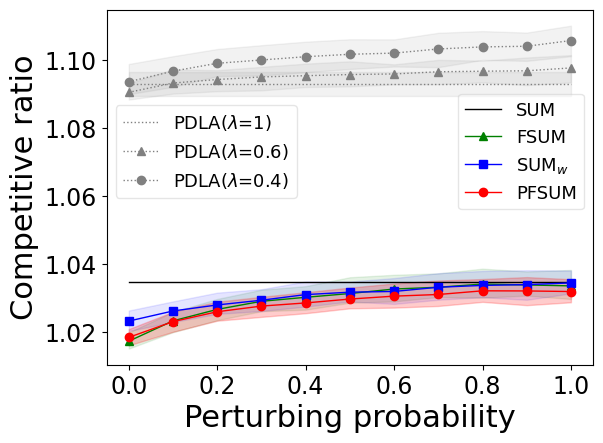

Commuters, Beta = 0.6, T = 10, C = 200, Price distribution = Pareto


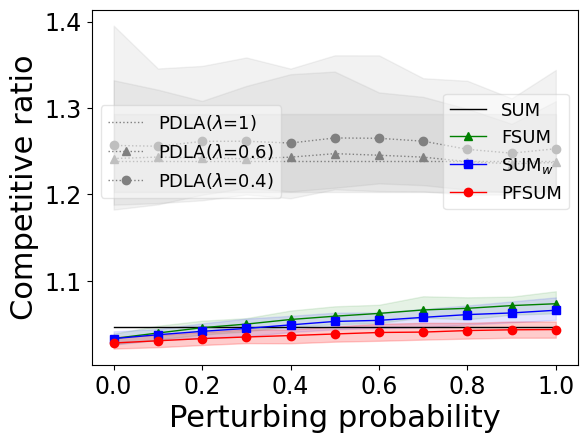

Commuters, Beta = 0.6, T = 10, C = 2000, Price distribution = Uniform


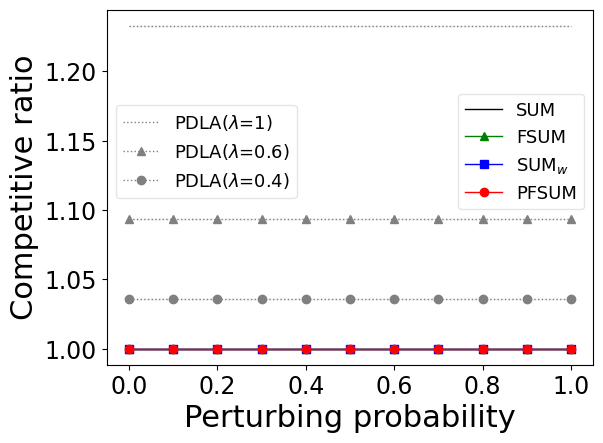

Commuters, Beta = 0.6, T = 10, C = 2000, Price distribution = Normal


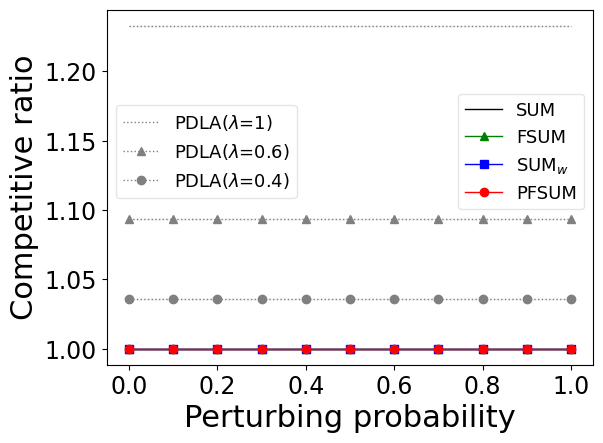

Commuters, Beta = 0.6, T = 10, C = 2000, Price distribution = Pareto


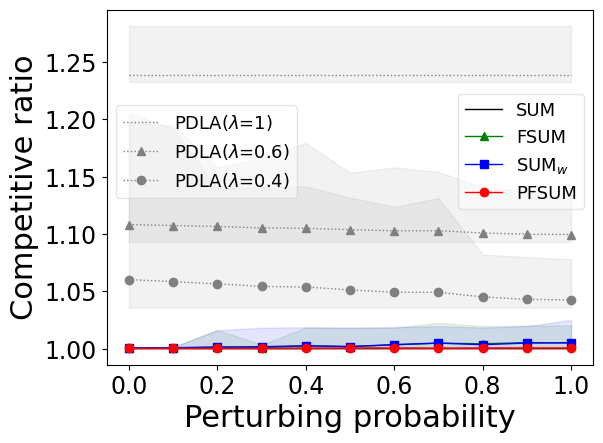

Commuters, Beta = 0.2, T = 10, C = 400, Price distribution = Uniform


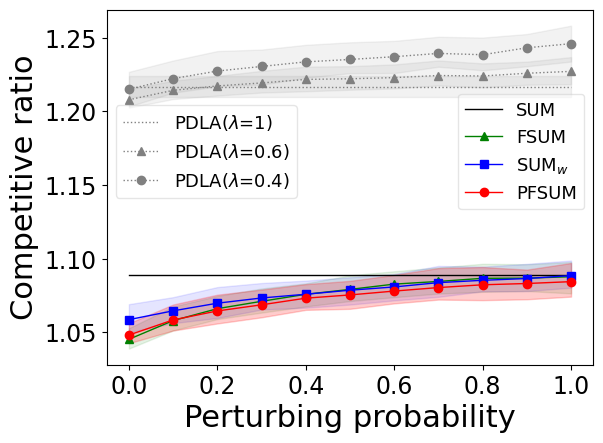

Commuters, Beta = 0.2, T = 10, C = 400, Price distribution = Normal


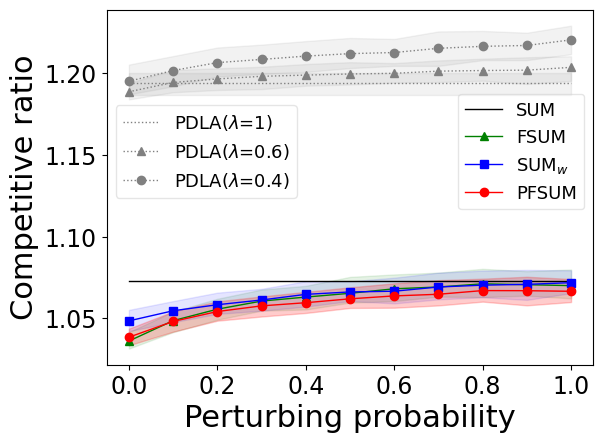

Commuters, Beta = 0.2, T = 10, C = 400, Price distribution = Pareto


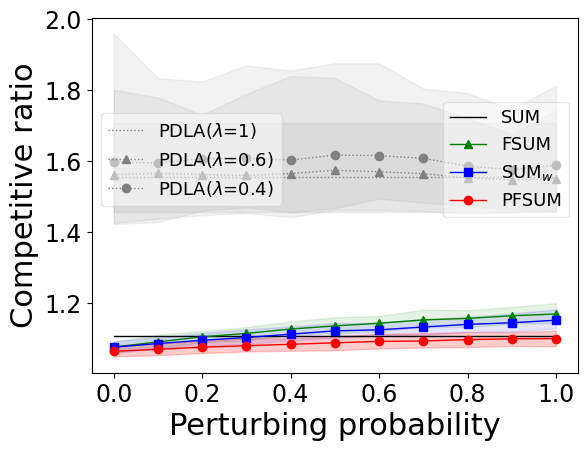

In [393]:
profile = "Commuters"
for param in parameter_sets:
    for price_dist in price_dists:
        plot_cr(param[0], param[1], param[2], price_dist, profile)

In [388]:
#for the occasional travelers, travel requests occur at intervals
parameter_sets = [(0.8, 10, 100), (0.6, 5, 100), (0.6, 10, 200), (0.6, 10, 2000), (0.2, 10, 400)]

for price_dist in price_dists:
    for exp_count in range(0, experiment_num):
        #generate an instance
        np.random.seed(exp_count)
        instance = ins.instance_generator(time_length, "Exponential", interval_mean, price_dist, price_mean)
        for perturb_prob in perturb_probabilitys:
            noisy_instance = ins.noisy_instance_generator(instance, price_dist, price_mean, perturb_prob)
            evaluate(instance, noisy_instance, parameter_sets, price_dist, perturb_prob)


Occasional_travelers, Beta = 0.8, T = 10, C = 100, Price distribution = Uniform


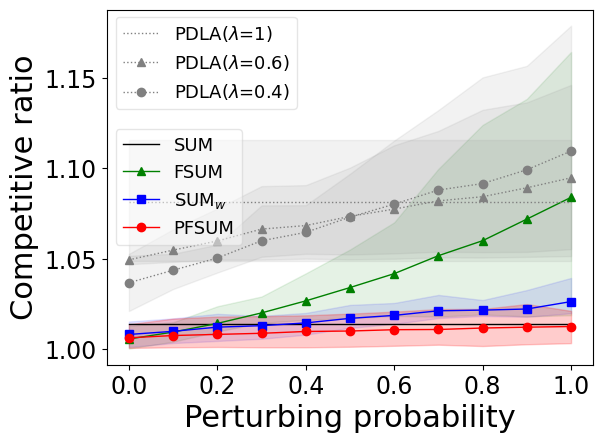

Occasional_travelers, Beta = 0.8, T = 10, C = 100, Price distribution = Normal


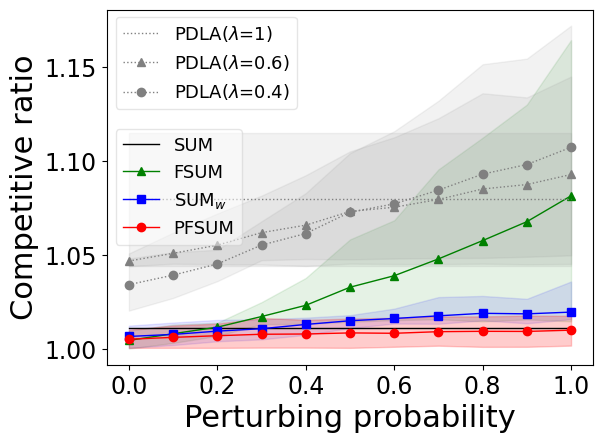

Occasional_travelers, Beta = 0.8, T = 10, C = 100, Price distribution = Pareto


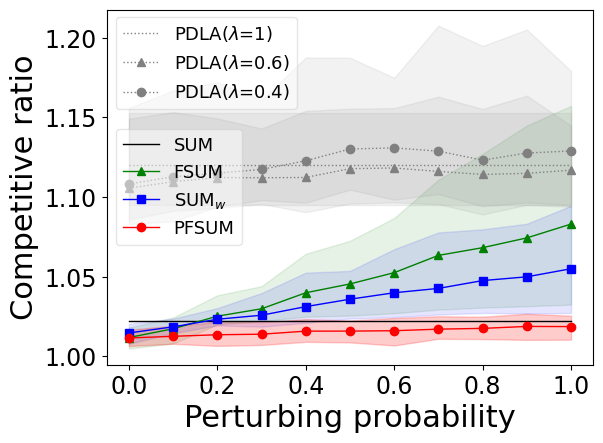

Occasional_travelers, Beta = 0.6, T = 5, C = 100, Price distribution = Uniform


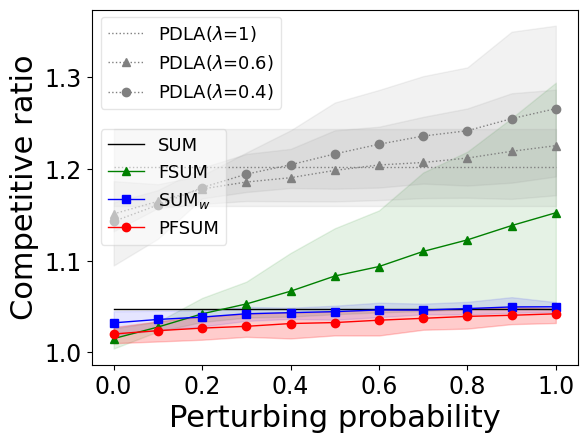

Occasional_travelers, Beta = 0.6, T = 5, C = 100, Price distribution = Normal


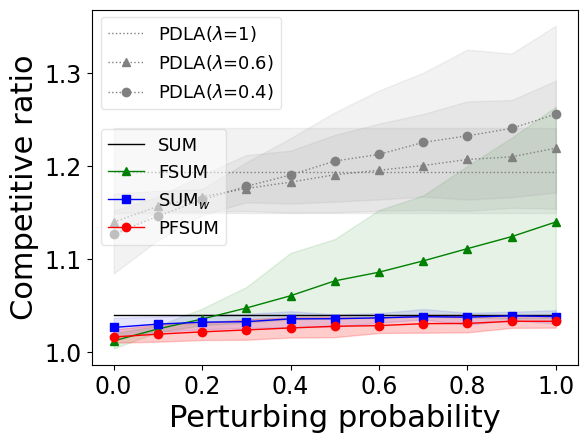

Occasional_travelers, Beta = 0.6, T = 5, C = 100, Price distribution = Pareto


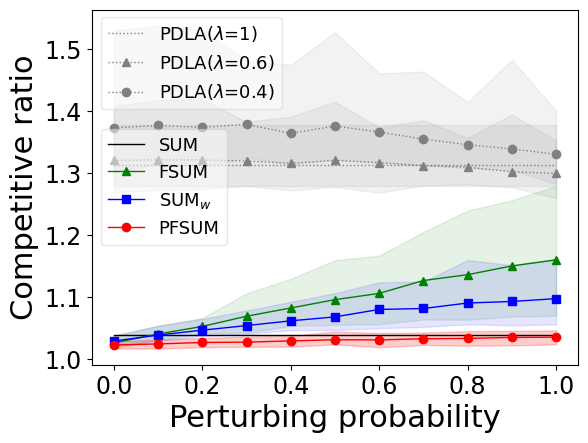

Occasional_travelers, Beta = 0.6, T = 10, C = 200, Price distribution = Uniform


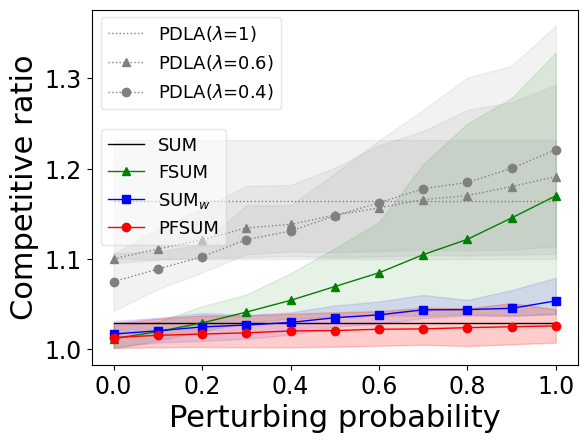

Occasional_travelers, Beta = 0.6, T = 10, C = 200, Price distribution = Normal


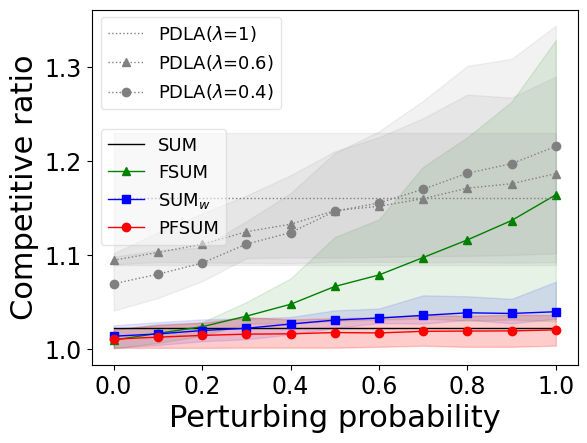

Occasional_travelers, Beta = 0.6, T = 10, C = 200, Price distribution = Pareto


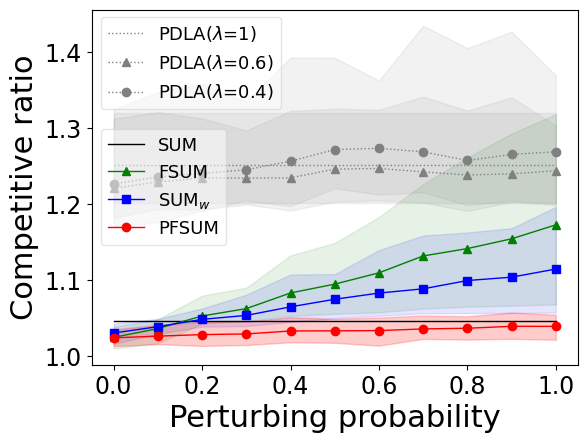

Occasional_travelers, Beta = 0.6, T = 10, C = 2000, Price distribution = Uniform


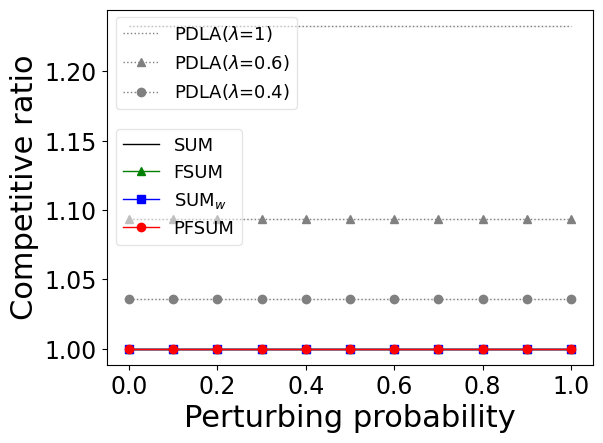

Occasional_travelers, Beta = 0.6, T = 10, C = 2000, Price distribution = Normal


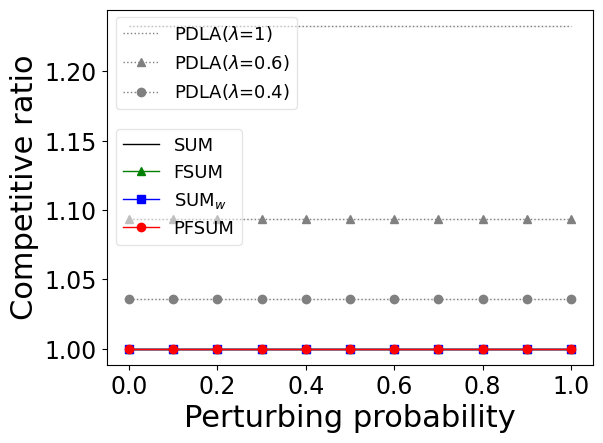

Occasional_travelers, Beta = 0.6, T = 10, C = 2000, Price distribution = Pareto


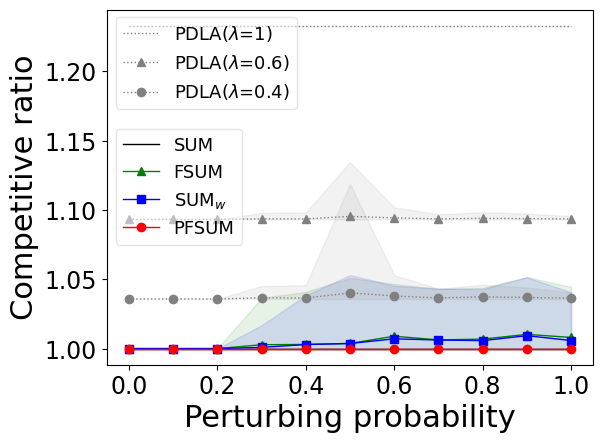

Occasional_travelers, Beta = 0.2, T = 10, C = 400, Price distribution = Uniform


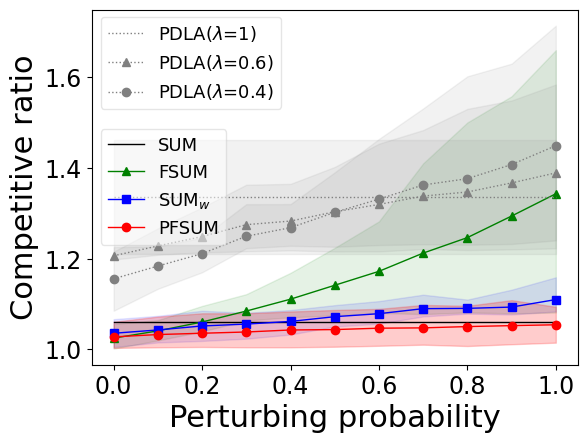

Occasional_travelers, Beta = 0.2, T = 10, C = 400, Price distribution = Normal


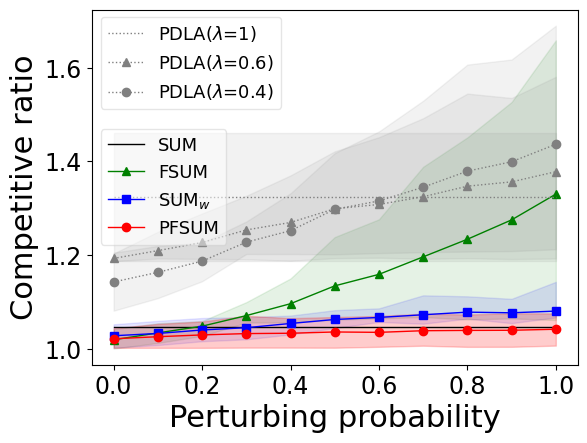

Occasional_travelers, Beta = 0.2, T = 10, C = 400, Price distribution = Pareto


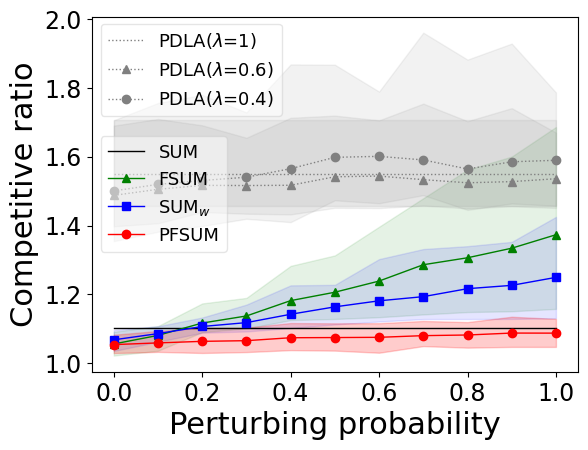

In [389]:
profile = "Occasional_travelers"
for param in parameter_sets:
    for price_dist in price_dists:
        plot_cr(param[0], param[1], param[2], price_dist, profile)
